# 1. 문제 정의

* **데이터셋 출처**
  https://www.kaggle.com/c/bike-sharing-demand

  

* **문제 정의**<br>
  자전거 대여일의 날씨, 계절 , 회원제 정보 등을 분석하여 자전거 대여량을 예측합니다. 구체적인 대여량 수치를 판단하는 문제이므로 '예측'문제로 정의할 수 있습니다 . '예측'문제를 해결하기위한 Regressor를 모델로 설정하고, 모델 평가는 실제대여량과 예측대여량의 수치를 비교하는 Mean squared error를 사용할 수 있습니다.

**Data Fields**

- datetime - 대여날짜 및 시간 
- season - 계절 (1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울 ) 
- holiday - 휴일 
- workingday - 주말과 휴일을 제외한 날 (평일) 
- weather - 날씨 * 1: 맑음, 대체로 흐림, 일부 흐림 * 2: 안개 + 흐림, 안개 + 깨진 구름, 안개 + 구름이 거의 없음, 안개 * 3: 가벼운 눈, 가벼운 비 + 뇌우 + 흩어진 구름, 가벼운 비 + 흩어진 구름 * 4: 폭우 + 얼음 팔레트 + 뇌우 + 안개, 눈 + 안개 
- temp - 섭씨 온도 
- atemp - 체감 온도 
- humidity - 상대 습도 
- windspeed - 풍속 
- casual - 미등록 사용자의 대여 횟수 
- registered - 등록된 사용자의 대여 횟수 
- count - 총 대여수

라이브러리 임포트

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
import tensorflow as tf

warnings.filterwarnings("ignore", category=RuntimeWarning)

seed = 0
np.random.seed(seed)

Using TensorFlow backend.


# 2. 데이터 전처리


데이터 전처리를 진행합니다. 원본 데이터를 로딩하고,  다음 과정을 수행합니다.

* EDA
* 결측치처리
* 이상치처리: EDA를 통해 이상치 여부를 확인하고, 이상치 데이터를 제거 또는 변환합니다.
* Object처리: Object타입 데이터는 수치형 데이터로 변환합니다.
* Categorical 데이터: 필드의 타입을 구분하기 위해 사용한 Categorical 데이터는 크기가 없는 숫자인 One-hot 형태로 변환합니다.
* X-Y 데이터 분할: 독립변수 X와 종속변수 Y로 데이터를 분할합니다.
* Train-Test 분할: 학습용 데이터셋과 테스트용 데이터셋으로 분할합니다. 학습용 데이터셋은 모델 학습(fit())시 사용하고, 테스트용 데이터셋은 모델 평가(predict() 후 accuracy 측정)에 사용합니다.

In [2]:
bike_df = pd.read_csv('./dataset/bike.csv')
bike_df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## (1) EDA

In [3]:
bike_df.shape

(10886, 12)

In [4]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


### 독립변수 탐색

#### 자전거 대여량의 분포 시각화

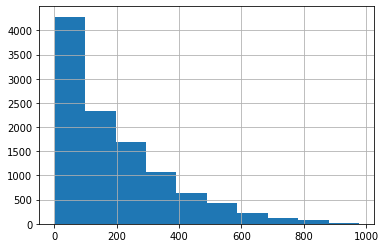

In [5]:
Y = bike_df['count']
Y.hist()

#### 자전거 대여량의 로그값 분포 시각화

독립변수가 정규분포를 따르도록 log를 활용하여 치우침 현상이 개선되는지 확인합니다.
numpy의 log1p() 함수를 사용합니다.

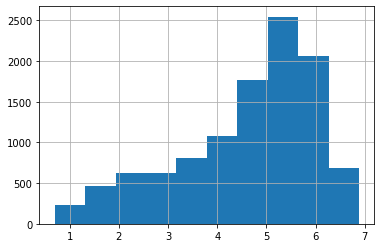

In [6]:
y_log = np.log1p(Y)
y_log.hist()

In [7]:
bike_df.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

## (2) 결측치 처리

In [8]:
bike_df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

## (3) Object처리
Object타입 데이터는 수치형 데이터로 변환합니다.

#### 'datetime' 타입 변환
'datetime'에 있는 값을 'year', 'month', 'day', 'hour' 필드에 파싱하여 넣습니다.<br>
예)
2011-01-01 00:00:00 -> 2011	1	1	0

python의 'datetime64' 포맷을 활용합니다.

In [9]:
bike_df['datetime'] = bike_df['datetime'].astype('datetime64')

bike_df['year'] = bike_df['datetime'].dt.year
bike_df['month'] = bike_df['datetime'].dt.month
bike_df['day'] = bike_df['datetime'].dt.day
bike_df['hour'] = bike_df['datetime'].dt.hour
bike_df['minute'] = bike_df['datetime'].dt.minute
bike_df['second'] = bike_df['datetime'].dt.second
bike_df['dayofweek'] = bike_df['datetime'].dt.dayofweek
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0,5


## (4) EDA2 
### 종속변수 탐색

[Text(0.5, 0, 'hour'), Text(0.5, 1.0, 'hourly shared')]

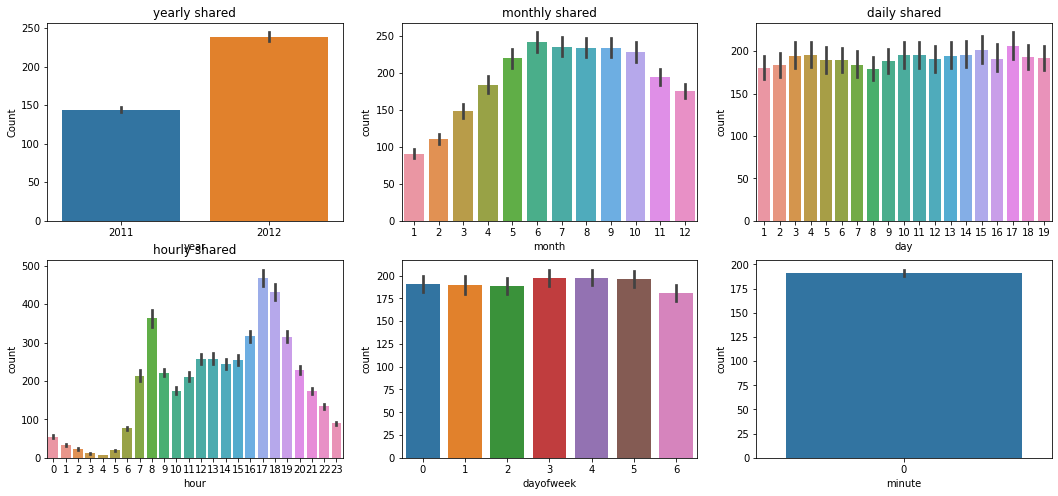

In [10]:
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18,8)

sns.barplot(data=bike_df, x="year", y="count", ax=ax1)
sns.barplot(data=bike_df, x="month", y="count", ax=ax2)
sns.barplot(data=bike_df, x="day", y="count", ax=ax3)
sns.barplot(data=bike_df, x="hour", y="count", ax=ax4)
sns.barplot(data=bike_df, x="dayofweek", y="count", ax=ax5)
sns.barplot(data=bike_df, x="minute", y="count", ax=ax6)

ax1.set(ylabel='Count',title="yearly shared")
ax2.set(xlabel='month',title="monthly shared")
ax3.set(xlabel='day', title="daily shared")
ax4.set(xlabel='hour', title="hourly shared")


- 연도별 대여량은 2011년 보다 2012년이 더 많다.
- 월별 대여량은 6월에 가장 많고 7~10월도 대여량이 많다. 그리고 1월에 가장 적다.
- 일별대여량은 1일부터 19일까지만 있고 나머지 날짜는 test.csv에 있다. 그래서 이 데이터는 피처로 사용하면 안 된다.
- 시간 대 대여량을 보면 출퇴근 시간에 대여량이 많은 것 같다. 하지만 주말과 나누어 볼 필요가 있을 것 같다.
- 분, 초도 다 0이기 때문에 의미가 없다.

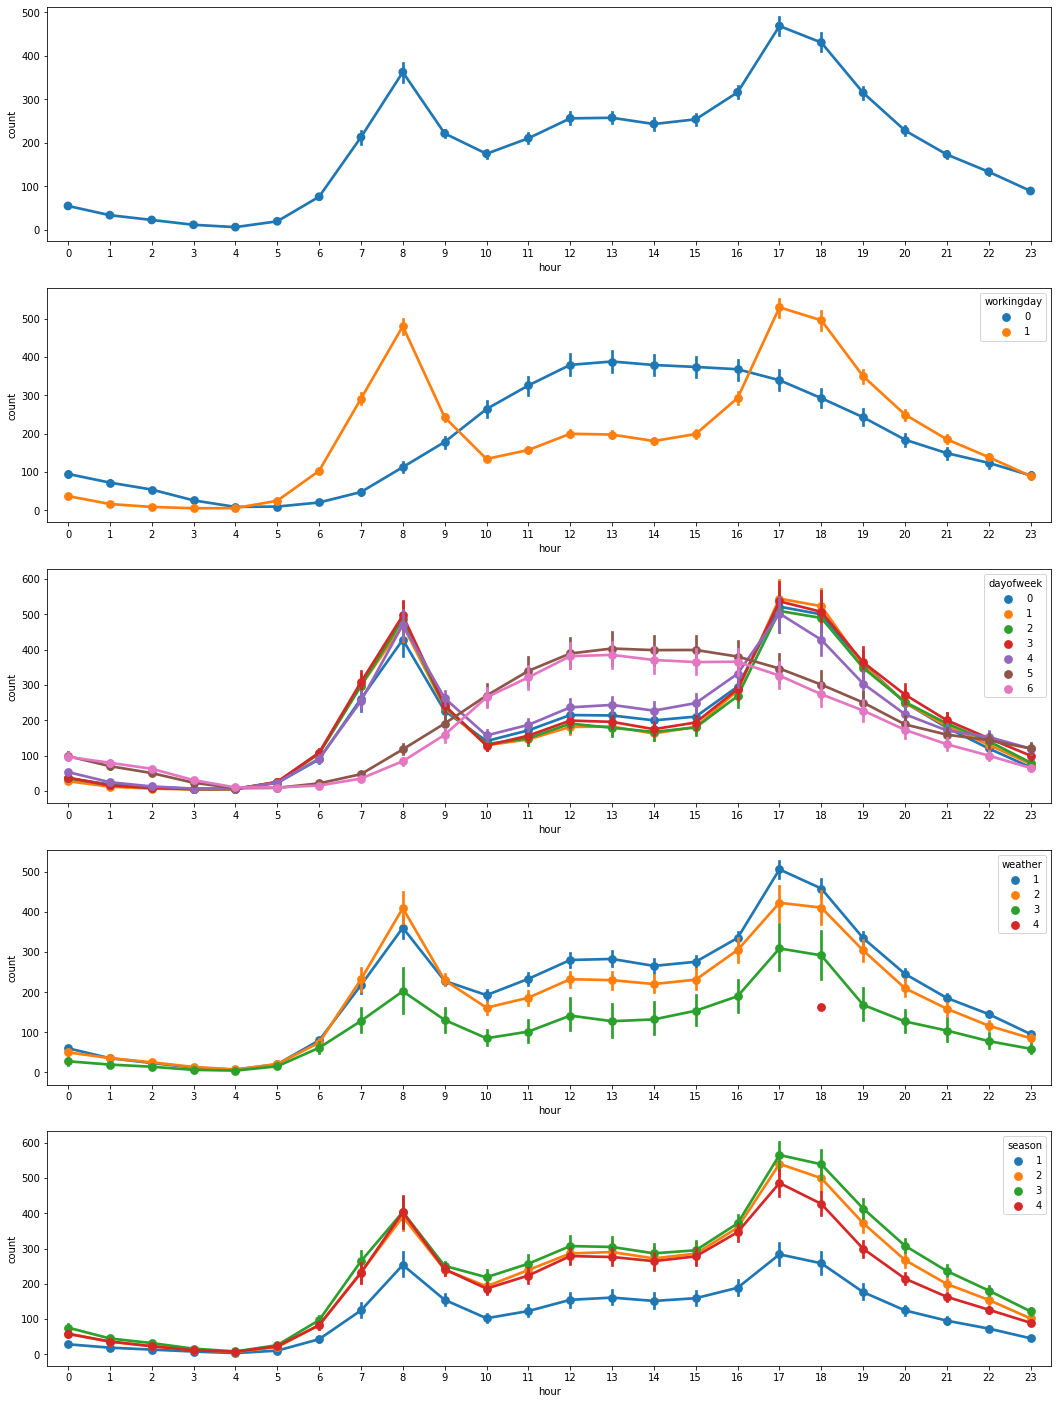

In [11]:
fig,(ax1,ax2,ax3,ax4,ax5)= plt.subplots(nrows=5)
fig.set_size_inches(18,25)
sns.pointplot(data=bike_df, x="hour", y="count", ax=ax1)
sns.pointplot(data=bike_df, x="hour", y="count", hue="workingday", ax=ax2)
sns.pointplot(data=bike_df, x="hour", y="count", hue="dayofweek", ax=ax3)
sns.pointplot(data=bike_df, x="hour", y="count", hue="weather", ax=ax4)
sns.pointplot(data=bike_df, x="hour", y="count", hue="season", ax=ax5)

## (5) X-Y 데이터 분할

독립변수 X와 종속변수 Y로 데이터를 분할합니다.

#### 불필요한 필드 제거

In [12]:
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1,inplace=True)
bike_df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,minute,second,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0,0,0,5
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1,0,0,5
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2,0,0,5
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3,0,0,5
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4,0,0,5


#### X-Y 데이터 분할

In [13]:
Y = bike_df['count']
X = bike_df.drop(['count'], axis=1,inplace=False)

## (6) Train-Test 분할

학습용 데이터셋과 테스트용 데이터셋으로 분할합니다. 학습용 데이터셋은 모델 학습(fit())시 사용하고, 테스트용 데이터셋은 모델 평가(predict() 후 accuracy 측정)에 사용합니다. train_test_split 함수를 사용해서 분리(train:test = 7:3, random_state=0)합니다

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

# 3. 학습모델1 (머신러닝)

### LinearRegression

In [15]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
pred = lr_model.predict(X_test)

### 정확도 측정
이 대회에서 정확도 평가는 RMSLE(Root Mean Squared Log Error)입니다. RMSLE는 아래 함수를 사용하세요

In [16]:
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    print('RMSLE: {0:.4f}'.format(rmsle))
    return rmsle

In [17]:
rmsle(y_test ,pred)

RMSLE: 1.1760


1.1760380772151604

### 다양한 회귀모델을 사용하여 모델링

* RandomForestRegressor
* GradientBoostingRegressor
* XGBRegressor
* LGBMRegressor

In [18]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# LinearRegression, 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=500)
gbm_model = GradientBoostingRegressor(n_estimators=500)
xgb_model = XGBRegressor(n_estimators=500)
lgbm_model = LGBMRegressor(n_estimators=500)

model_list = [lr_model, rf_model, gbm_model, xgb_model, lgbm_model]
for model in model_list:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print('###',model.__class__.__name__,'###')
    rmsle(y_test, pred)

### LinearRegression ###
RMSLE: 1.1760
### RandomForestRegressor ###
RMSLE: 0.3377
### GradientBoostingRegressor ###
RMSLE: 0.5855
[21:10:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
### XGBRegressor ###
RMSLE: 0.5803
### LGBMRegressor ###
RMSLE: 0.4334


# 4. 학습모델2 (딥러닝)

개선 모델에서 모델링

# 5. 개선

### 예측값과 실제값의 차이가 가장 많이 나는 데이터 5개 출력

In [19]:
def get_top5_error_data(y_test, pred):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성. 
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력. 
    print(result_df.sort_values('diff', ascending=False)[:5])
    
get_top5_error_data(y_test,pred)

      real_count  predicted_count   diff
2592         565            220.0  345.0
1978         134            468.0  334.0
565          512            195.0  317.0
1622         370            674.0  304.0
1095         743            483.0  260.0


## (1) 데이터 개선

#### Y의 로그값을 사용하여 모델 만들어보기

In [20]:
# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3, random_state=seed)

In [21]:
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        # 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
        y_test = np.expm1(y_test)
        # 예측 값 역시 Log 변환된 타겟 기반으로 학습되어 예측되었으므로 다시 exmpl으로 scale변환
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    rmsle(y_test, pred)

In [22]:
# LinearRegression, 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=500)
gbm_model = GradientBoostingRegressor(n_estimators=500)
xgb_model = XGBRegressor(n_estimators=500)
lgbm_model = LGBMRegressor(n_estimators=500)

model_list = [lr_model, rf_model, gbm_model, xgb_model, lgbm_model]
for model in model_list:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 1.0159
### RandomForestRegressor ###
RMSLE: 0.3132
### GradientBoostingRegressor ###
RMSLE: 0.2980
[21:10:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
### XGBRegressor ###
RMSLE: 0.3004
### LGBMRegressor ###
RMSLE: 0.2807


#### 선형회귀모델에서 가장 영향을 많이 주는 종속변수 알아보기

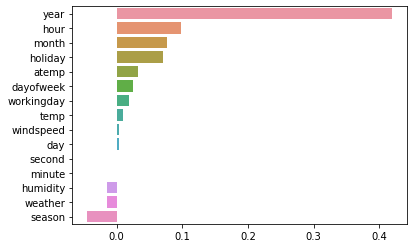

In [23]:
def plotFeatureList(model, X):
    coef = pd.Series(model.coef_, index=X.columns)
    coef_sort = coef.sort_values(ascending=False)
    sns.barplot(x=coef_sort.values, y=coef_sort.index)

plotFeatureList(lr_model, X)

#### 수치형 데이터 중 카테고리형 데이터 One Hot Encoding 하기

In [24]:
# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
x_one_hot = pd.get_dummies(X, columns=['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])

# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할. 
X_train, X_test, y_train, y_test = train_test_split(x_one_hot, y_log, test_size=0.3, random_state=seed)

In [25]:
# LinearRegression, 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=500, Randomseeed = random)
gbm_model = GradientBoostingRegressor(n_estimators=500)
xgb_model = XGBRegressor(n_estimators=500)
lgbm_model = LGBMRegressor(n_estimators=500)

model_list = [lr_model, rf_model, gbm_model, xgb_model, lgbm_model]
for model in model_list:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 0.5879
### RandomForestRegressor ###
RMSLE: 0.3379
### GradientBoostingRegressor ###
RMSLE: 0.3341
[21:11:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
### XGBRegressor ###
RMSLE: 0.3306
### LGBMRegressor ###
RMSLE: 0.2985


## (2) 모델의 개선 - 딥러닝

In [26]:
model = Sequential()
model.add(Dense(30, input_dim= X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dense(6, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error',
              optimizer='adam',
             metrics=['mse'])

model.fit(X_train, y_train, epochs=10, batch_size=10)

# 예측 값과 실제 값의 비교
pred = model.predict(X_test).flatten()
print('###',model.__class__.__name__,'###')
rmsle(y_test, pred)    

Epoch 1/10
7620/7620 [==============================] - 1s 142us/step - loss: 3.1757 - mse: 3.1757
Epoch 2/10
7620/7620 [==============================] - 1s 113us/step - loss: 0.6479 - mse: 0.6479
Epoch 3/10
7620/7620 [==============================] - 1s 127us/step - loss: 0.5825 - mse: 0.5825
Epoch 4/10
7620/7620 [==============================] - 1s 110us/step - loss: 0.5460 - mse: 0.5460
Epoch 5/10
7620/7620 [==============================] - 1s 108us/step - loss: 0.5171 - mse: 0.5171
Epoch 6/10
7620/7620 [==============================] - 1s 112us/step - loss: 0.4900 - mse: 0.4900
Epoch 7/10
7620/7620 [==============================] - 1s 123us/step - loss: 0.4692 - mse: 0.4692
Epoch 8/10
7620/7620 [==============================] - 1s 112us/step - loss: 0.4349 - mse: 0.4349
Epoch 9/10
7620/7620 [==============================] - 1s 126us/step - loss: 0.3767 - mse: 0.3767 0s - loss: 0.3576 - mse
Epoch 10/10
7620/7620 [==============================] - 1s 126us/step - loss: 0.3637

0.11942182741203913